# 1 Text mining

Let us consider the following document-term matrix $A$

In [107]:
import sklearn
import numpy as np
import sklearn.feature_extraction

np.set_printoptions(suppress=True)

vectorizer = sklearn.feature_extraction.text.CountVectorizer(min_df=1)

documents = [
    'The graph of a function in two variable is a surface in the 3D space',
    'The partial derivative is the ordinary derivative of a partial function',
    'The gradient of a two-variables function contains its partial derivatives',
    'The partial derivatives are the slope of the tangent plane',
    'The tangent plane is the linear approximation of a surface',
    'If a function is convex then any local minimizer is a global minimizer',
    'A steepest descent method uses the opposite of the gradient direction',
    'The steepest descent method is globally convergent if the Wolfe condition holds',
    'The Hessian matrix is the matrix of second-order partial derivatives',
    'The Hessian matrix of a convex function is positive semi-definite'
]

X = vectorizer.fit_transform(documents).toarray()
print('vectorizer.vocabulary_: {0}'.format(vectorizer.vocabulary_))

A = X.T
print(A.shape)

vectorizer.vocabulary_: {'the': 43, 'graph': 17, 'of': 29, 'function': 13, 'in': 21, 'two': 45, 'variable': 47, 'is': 22, 'surface': 41, '3d': 0, 'space': 39, 'partial': 33, 'derivative': 9, 'ordinary': 32, 'gradient': 16, 'variables': 48, 'contains': 5, 'its': 23, 'derivatives': 10, 'are': 3, 'slope': 38, 'tangent': 42, 'plane': 34, 'linear': 24, 'approximation': 2, 'if': 20, 'convex': 7, 'then': 44, 'any': 1, 'local': 25, 'minimizer': 28, 'global': 14, 'steepest': 40, 'descent': 11, 'method': 27, 'uses': 46, 'opposite': 30, 'direction': 12, 'globally': 15, 'convergent': 6, 'wolfe': 49, 'condition': 4, 'holds': 19, 'hessian': 18, 'matrix': 26, 'second': 36, 'order': 31, 'positive': 35, 'semi': 37, 'definite': 8}
(50, 10)


First do a bit of data preprocessing to have better results.

In [108]:
from gensim.parsing.preprocessing import remove_stopwords, stem_text
L = []
for i in range(len(documents)):
    L.append(remove_stopwords(documents[i]))
print('\n List of documents without stop words\n ', L)

L_final = []
for i in range(len(documents)):
    L_final.append(stem_text(L[i]))
print('\n List of documents after stemming \n ', L_final)

Y = vectorizer.fit_transform(L_final).toarray()
print('vectorizer.vocabulary_: {0}'.format(vectorizer.vocabulary_))

A = Y.T
print(A.shape)



 List of documents without stop words
  ['The graph function variable surface 3D space', 'The partial derivative ordinary derivative partial function', 'The gradient two-variables function contains partial derivatives', 'The partial derivatives slope tangent plane', 'The tangent plane linear approximation surface', 'If function convex local minimizer global minimizer', 'A steepest descent method uses opposite gradient direction', 'The steepest descent method globally convergent Wolfe condition holds', 'The Hessian matrix matrix second-order partial derivatives', 'The Hessian matrix convex function positive semi-definite']

 List of documents after stemming 
  ['the graph function variabl surfac 3d space', 'the partial deriv ordinari deriv partial function', 'the gradient two-vari function contain partial deriv', 'the partial deriv slope tangent plane', 'the tangent plane linear approxim surfac', 'if function convex local minim global minim', 'a steepest descent method us opposit gradi

Given the following query: "convex function"

In [109]:
 #query vector
query1text = ['convex function']
query_stem = query1text[0]
query1 = []
query1.append(query_stem)
query1 = vectorizer.transform(query1).toarray()

To search for the relevant documents, compute the cosine similarity between the query vector and the documents vectors.
Compare the method using the cosine similarity with the optimized method using a low rank approximation computed with the QR decomposition and  the reduced rank vector model using the singular value decomposition called Latent semantic indexing. (For the theory see the article in the file section of the Teams channel named vectorspacemodelxIR_SIAMreview1999.pdf, the lectures   6_Cosine_LinearCorrelation, RM_Lecture10_12_21, 08_31_projectors.pdf, Example 5.12.4 of the Meyer book)

In [110]:
import scipy.linalg as spl
(m,n)=A.shape
# calculate the euclidean norms of each column of A
eu = np.array(np.zeros(n))
for i in range(n):
    eu[i] = np.linalg.norm(A[:,i],2)

# normalize columns of matrix A in respect of norm of selected column
# (in this way we don't need to normalize the documents when calculating cosine similarity)
As = np.dot(A,np.diag(1/eu))

# cos of the angles:  cos(teta) = x^T y / (||x||*||y||)
similarity = np.dot(As.T,query1[0])/np.linalg.norm(query1[0],2) #we don't put the norm of the i-th column, we do all the calculation for each document in one row
print("Similarity query documents:\n", similarity.T)
print("Sorted relevant docs:", np.argsort(-similarity.T)[:])


Similarity query documents:
 [0.26726124 0.21320072 0.25       0.         0.         0.47140452
 0.         0.         0.         0.5       ]
Sorted relevant docs: [9 5 0 2 1 3 4 6 7 8]


## LOW RANK APPROXIMATION WITH QR

Let compute the QR factorization.

In [111]:
[Q,R,P]=spl.qr(As,mode = 'economic',pivoting=True)  # QR factorization with pivoting on the scaled 
# In general, it is necessary to use column pivoting during the QR factorization to ensure that the zeros appear at the bottom of the matrix AP = QR
print('Q')
print(Q.shape)
print('R')
print(R.shape)
print('P')
print(P.shape)

import numpy.linalg as npl
print("Rank of the original matrix: ",npl.matrix_rank(As))

Q
(41, 10)
R
(10, 10)
P
(10,)
Rank of the original matrix:  10


In [112]:
QA=np.copy(Q[:,0:npl.matrix_rank(As)])
# QA basis for the column space of A
print(QA.shape)
RA=np.copy(R[0:npl.matrix_rank(As),:])
print(RA.shape)
# In general, it is necessary to use column pivoting during the QR factorization to ensure that the zeros appear  at the bottom of the matrix AP = QR

A_r=np.dot(QA,RA)[:,np.argsort(P)]
      
# cos of the angles:  cos(teta) = x^T y / (||x||*||y||)
sim=np.dot(A_r.T,query1[0])/np.linalg.norm(query1[0],2) #we don't put the norm of the i-th column
print("Similarity query documents:\n", sim.T)
print("Sorted relevant docs:", np.argsort(-sim.T)[:])



(41, 10)
(10, 10)
Similarity query documents:
 [0.26726124 0.21320072 0.25       0.         0.         0.47140452
 0.         0.         0.         0.5       ]
Sorted relevant docs: [9 5 0 2 1 7 4 8 3 6]


We can see that we have the same result wrt the original matrix.
For our purposes, it could be better to have less information in the term document matrix because we want to query in a "less-noise space".

As descibed in the article, the QR factorization with pivoting tends to separate the large and small parts of the matrix, pushing the larger entries toward the upper left corner of the matrix and the smaller ones toward the lower right.
So, we can choose a set of tollerances that describes relative changes in the value of R that makes the same-sized change in A (our therm document matrix), and the compute the cosine similarity wrt to this lower rank matrices.

Let us see what happen.



In [125]:
#extract the diagonal of R, normalize it with a norm
Rdiag = np.abs(np.diag(R))
Rdiag = Rdiag/Rdiag.max()  #wrt the norm infinite

# choose a set of tolerances
tols = [.9, .7, .3, .1, 1e-2]

# array that contains the number of cols of the different low rank approximations
nc_list = [] 

for tol in tols:
    nc=0    #number of values from diagonal greater than tolerance
    for i in range(0,Rdiag.shape[0]):
        if(Rdiag[i]>tol):
            nc+=1
    nc_list.append(nc)  #save the nc value

    #reducing the matrices
    QA=np.copy(Q[:,0:nc]) #copying first nc columns of Qimg
    RA=np.copy(R[0:nc,:]) #copying first nc rows of Rimg

    #Use this approximation to compute again the cosine similarity:
    #calculate the approximate matrix by calculating: A = Q*R*P^T
    print("tol=",tol , "     numb col =", nc, "/", Rdiag.size)
    A_r=np.dot(QA,RA)[:,np.argsort(P)]

    # cos of the angles:  cos(teta) = x^T y / (||x||*||y||)
    sim=np.dot(A_r.T,query1[0])/np.linalg.norm(query1[0],2) #we don't put the norm of the i-th column

    print("Similarity query documents:\n", sim.T)
    print("Sorted relevant docs:", np.argsort(-sim.T)[:])
    print("---------------------------------------------------------------")



tol= 0.9      numb col = 6 / 10
Similarity query documents:
 [0.26726124 0.10338985 0.14522601 0.         0.05294343 0.47140452
 0.         0.         0.15790815 0.5       ]
Sorted relevant docs: [9 5 0 8 2 1 4 7 3 6]
---------------------------------------------------------------
tol= 0.7      numb col = 9 / 10
Similarity query documents:
 [0.26726124 0.12313359 0.25       0.         0.         0.47140452
 0.         0.         0.         0.5       ]
Sorted relevant docs: [9 5 0 2 1 7 4 8 3 6]
---------------------------------------------------------------
tol= 0.3      numb col = 10 / 10
Similarity query documents:
 [0.26726124 0.21320072 0.25       0.         0.         0.47140452
 0.         0.         0.         0.5       ]
Sorted relevant docs: [9 5 0 2 1 7 4 8 3 6]
---------------------------------------------------------------
tol= 0.1      numb col = 10 / 10
Similarity query documents:
 [0.26726124 0.21320072 0.25       0.         0.         0.47140452
 0.         0.         0

## SVD (Latent Semantic Index)

We now factorize the term document matrix using the SVD decomposition instead of the QR factorization.
The singular value decomposition of the term document matrix is:

A = U * S * V^T with U, V orhogonal and S diagonal matrix

We need to build S diagonal using the singual values returned by svd(A) on the diagonal and 0 otherwise.

In [126]:
U, Sv, Vt = np.linalg.svd(A)      #A = U*S*V^T
# Sv is a vector containing the singular values, we put the element in a diagonal matrix S
S = np.zeros((m,n),'float64')   #create a matrix with all zeros of size m and n
S[0:n,0:n] = np.diag(Sv)        #populate the diagonal values of S, we use n as the lower dimension
V = Vt.T                        #calculate transpose of V   

Then we use the nc computed in the first part of the exercise, to reduce the U, S and V matrices

We can precompute the product SA*VA^T, in order to optimize the calculus of the similarity, as the norm of this product which will go on the denominator.

The cosine similarity is: 

cos(teta) = s^T *(UA^T * query) / (||s|| * ||query||)

We then extract the relevant document, sorted by relevance:

In [128]:
for nc in nc_list:
    print('numb col =', nc) #we use the nc calculated in the first part
    
    #reducing the matrices:
    UA = np.copy(U[:,0:nc])    #copying first nc columns of U
    SA = np.copy(S[0:nc,0:nc]) #copying first nc rows and columns of S
    VA = np.copy(V[:,0:nc])    #copying first nc columns of V

    e = np.eye(n)

    SV = []
    for j in range(n):
        SV.append(np.dot(SA,np.dot(VA.T,e[j])))  # we compute in advance the product SA*VA^T, after we'll compute the product with Uk
        
    # we calculate the norm of s (we'll put it on the denominator of the cosine similarity)
    SV_norm=[]
    for j in range(n):
        SV_norm.append(np.linalg.norm(SV[j],2))

    sim=[]
    for j in range(n):
      sim.append( (  np.dot(SV[j].T,np.dot(UA.T,query1[0]))  / (SV_norm[j]*np.linalg.norm(query1[0],2)) )  .item() )
    similarity = np.array(sim)

    print("Similarity query documents:\n", similarity)
    print("--> Sorted relevant docs:", np.argsort(-similarity)[:])
    print('----------------------------------------------\n')

numb col = 6
Similarity query documents:
 [ 0.37183174  0.18523754  0.29688317 -0.02572205 -0.02694311  0.50940225
 -0.0225428   0.0116531   0.09458597  0.42880415]
--> Sorted relevant docs: [5 9 0 2 1 8 7 6 3 4]
----------------------------------------------

numb col = 9
Similarity query documents:
 [ 0.27289291  0.20658246  0.25204292  0.02364162 -0.01542221  0.47192732
 -0.00024965 -0.00020276 -0.00009956  0.50044597]
--> Sorted relevant docs: [9 5 0 2 1 3 8 7 6 4]
----------------------------------------------

numb col = 10
Similarity query documents:
 [ 0.26726124  0.21320072  0.25        0.          0.          0.47140452
 -0.         -0.         -0.          0.5       ]
--> Sorted relevant docs: [9 5 0 2 1 4 3 6 8 7]
----------------------------------------------

numb col = 10
Similarity query documents:
 [ 0.26726124  0.21320072  0.25        0.          0.          0.47140452
 -0.         -0.         -0.          0.5       ]
--> Sorted relevant docs: [9 5 0 2 1 4 3 6 8 7]
--

# 2 Page Ranking

Given the following simplified web model, first construct the hyperlink matrix and then construct the Google matrix to compute the page with the highest importance via the power-method


<div>
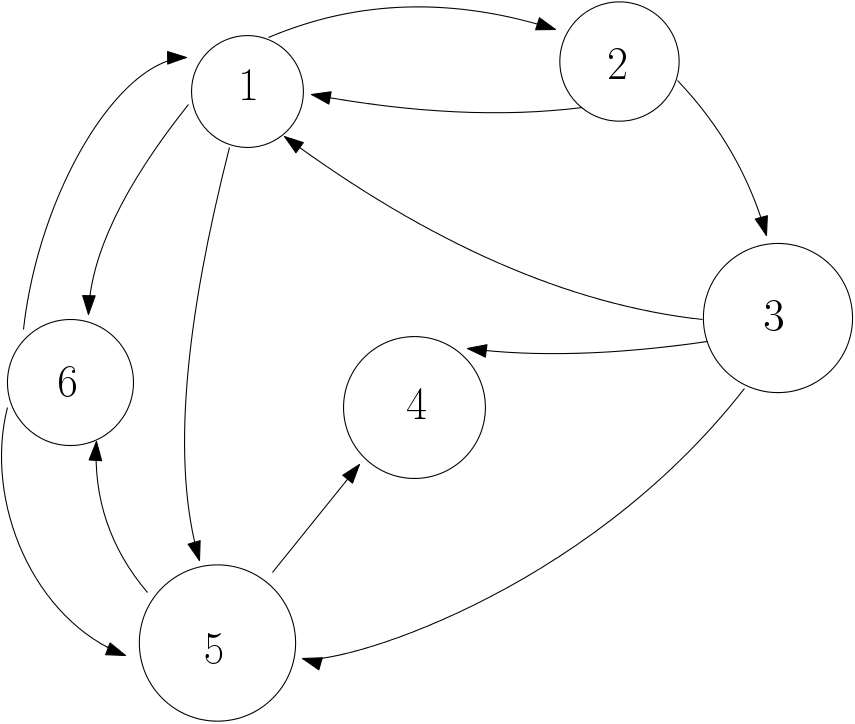
</div>

(For the theory related to this example look in File/Codice/Python/Power Method and Google Page Ranking.ipynb )

# 3 PERCEPTRON

Implement a model that describe a  classifier that divides the coordinate plane into two halves, the line in the test data  is y=-3*x. We want to learn a parameter vector such that our model make the right prediction. This model is called a  perceptron. The cost function minimizes the distance in the two norm. 


In [114]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot

use the following neuron

In [115]:
def phi(t): return (1-np.exp(-t))/(1+np.exp(-t))
def neuron(w,b,x):return phi(np.inner(w,x)+b)

Train the neuron with the following  data

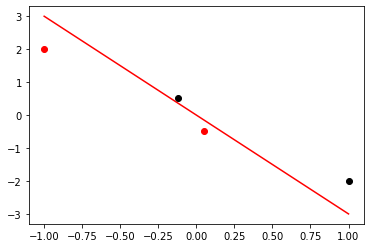

In [116]:
data = np.array([[[1,-2],+1],
       [[-1,2],-1],
       [[-0.12,0.52],1],
       [[0.05,-0.48],-1]],dtype=object)

data1 = np.array([p[0] for p in data if p[1]>0])
data2 = np.array([p[0] for p in data if p[1]<0])

matplotlib.pyplot.plot([-1,1],[3,-3],'r', data1[::,0], data1[::,1],'ko',  data2[::,0], data2[::,1],'ro');

Find the correct label for the following random dataset:

dataset = np.random.randn(100,2)

using scipy.optimize.minimize and implementing the line search method with the steepest descend direction and constant value of the step-length and the line search method with the backtraking approach for the computation of the step-length at each iteration. Compare the results of the three methods.

(For the theory realted to this exercise see VM_Lecture05_01_22, 08_31_Methods_for_NonlinearSystems__Perceptron.pdf, section 3.1 of the book Numerical Optimization by Jorge Nocedal and  Stephen Wright and chapter 1 and first part of chapter 2 2 of the book Nikhil Buduma, Nicholas Locascio - Fundamentals of Deep Learning_ Designing Next-Generation Machine Intelligence Algorithms (2017, O’Reilly Media)  )